# Experiment: Latent Variable Sampling in a Graph-Based Model

## Objective
The goal of this experiment is to explore the probabilistic modeling component of the **Graph-EFM** framework by generating and sampling the latent variable \( Z \) in a toy graph-based setting. This allows us to:
- Understand how uncertainty is modeled and propagated in a graph.
- Experiment with different parameters (e.g., variance of \( Z \), graph structure).
- Visualize the impact of \( Z \) on the final output.

---

## Key Components

### 1. **Graph Construction**
- A toy graph is created with `num_nodes` nodes and random features.
- Edges connect every node to every other node (fully connected graph).

### 2. **GNN Encoder**
- A Graph Neural Network (GNN) encodes node features into the mean of the latent variable \( \mu_Z \).
- The GNN uses **GCNConv** layers from PyTorch Geometric.

### 3. **Latent Variable \( Z \)**
- \( Z \) is sampled from a Gaussian distribution \( \mathcal{N}(\mu_Z, \sigma_Z^2) \).
- The reparameterization trick is used for differentiable sampling:
  \[
  Z = \mu_Z + \sigma_Z \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, 1)
  \]

### 4. **Decoder**
- A simple Multi-Layer Perceptron (MLP) maps \( Z \) back to an output space (e.g., a weather variable).

### 5. **Visualization**
- Heatmaps are used to visualize:
  - The mean of \( Z \) (`mu_Z`).
  - Sampled \( Z \).
  - Decoded output.

---

## Code Overview

```python
# Key steps in the code:
# 1. Create a toy graph with random features.
# 2. Encode node features into mu_Z using a GNN.
# 3. Sample Z from a Gaussian distribution.
# 4. Decode Z into an output.
# 5. Visualize mu_Z, Z, and the decoded output.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
import numpy as np


In [3]:

class GNNEncoder(nn.Module):
    '''Graph Neural Network (GNN) for encoding'''
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GNNEncoder, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, latent_dim)
        
    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class Decoder(nn.Module):
    '''simple decoder to map Z back to output space'''
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, z):
        return self.mlp(z)


### Toy graph setup


In [4]:

def create_toy_graph(num_nodes, input_dim):
    edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j], dtype=torch.long).t().contiguous()
    x = torch.randn(num_nodes, input_dim)  # Random node features
    return Data(x=x, edge_index=edge_index)


In [5]:

# Parameters
input_dim = 10  # Input feature dimension for each node
hidden_dim = 16  # Hidden dimension in GNN
latent_dim = 5   # Dimension of latent variable Z
output_dim = 1   # Output dimension (e.g., a single weather variable)
num_nodes = 10   # Number of nodes in the graph
sigma_Z = 1.0    # Fixed standard deviation for Z


In [6]:
# Create toy graph
graph = create_toy_graph(num_nodes, input_dim)

# Initialize encoder and decoder
encoder = GNNEncoder(input_dim, hidden_dim, latent_dim)
decoder = Decoder(latent_dim, hidden_dim, output_dim)

# Forward pass: encode, sample Z, and decode
mu_Z = encoder(graph.x, graph.edge_index)  # Encode to get mu_Z
epsilon = torch.randn_like(mu_Z)           # Sample noise
Z = mu_Z + sigma_Z * epsilon               # Reparameterization trick
output = decoder(Z)                        # Decode Z to output


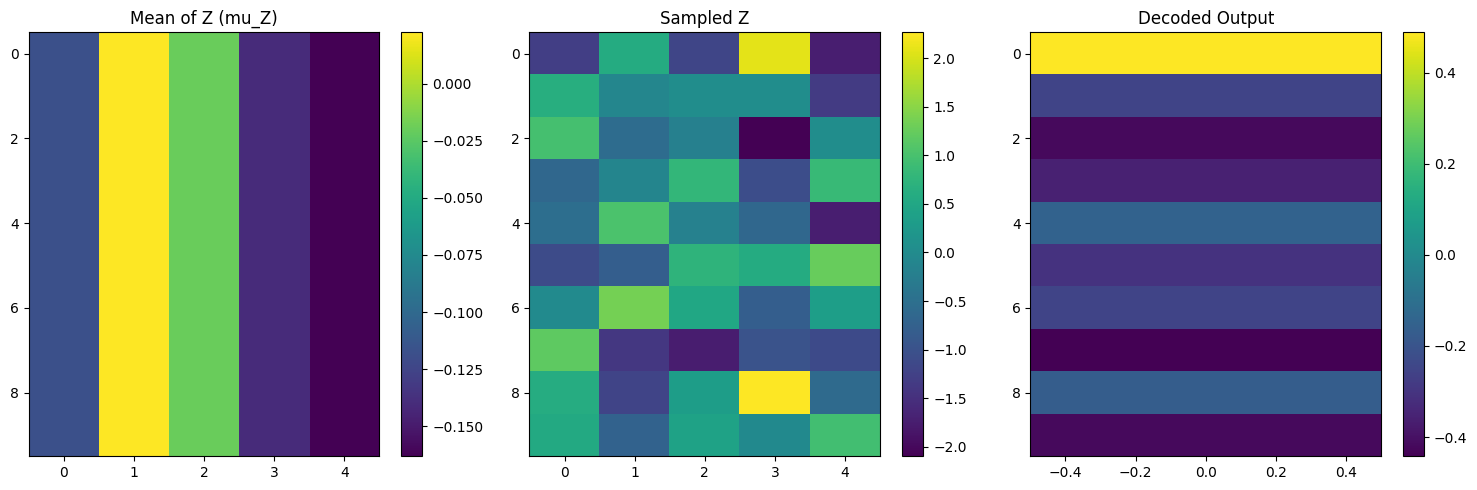

Mean of Z (mu_Z):
 [[-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]
 [-0.11747821  0.02250174 -0.019617   -0.14060555 -0.16316412]]
Sampled Z:
 [[-1.290394    0.58208835 -1.1928798   2.080845   -1.727859  ]
 [ 0.6419918  -0.08921107  0.04506375  0.04431844 -1.3465053 ]
 [ 0.9862526  -0.5549104  -0.20221432 -2.096143    0.0334803 ]
 [-0.6384627  -0.11238224  0.79750663 -1.0617903   0.83772874]
 [-0.52791923  1.0296586  -0.1782112  -0.6394065  -1.7241313 ]
 [-1.1060135  -0.796055

In [7]:

def visualize_results(mu_Z, Z, output):
    plt.figure(figsize=(15, 5))
    
    #  mu_Z (mean of Z)
    plt.subplot(1, 3, 1)
    plt.title("Mean of Z (mu_Z)")
    plt.imshow(mu_Z.detach().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar()
    
    #  sampled Z
    plt.subplot(1, 3, 2)
    plt.title("Sampled Z")
    plt.imshow(Z.detach().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar()
    
    #  decoded output
    plt.subplot(1, 3, 3)
    plt.title("Decoded Output")
    plt.imshow(output.detach().numpy(), cmap='viridis', aspect='auto')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()

visualize_results(mu_Z, Z, output)

#  values for debugging
print("Mean of Z (mu_Z):\n", mu_Z.detach().numpy())
print("Sampled Z:\n", Z.detach().numpy())
print("Decoded Output:\n", output.detach().numpy())